In [5]:
# to load and transform image datasets to tensor
from datasets import load_dataset, VerificationMode
from datasets.arrow_dataset import Dataset
# diffusers model
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# Text processing
from transformers import CLIPTextModel, CLIPTokenizer

# Image processing
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode

/Users/mynguyen/Repos/METCS777-GenAIForTheme/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Images
Using the imagefolder feature of HuggingFace's load_dataset

In [6]:
img_dataset: Dataset = load_dataset("imagefolder", data_dir="../raw_data/harvard/paintings/", split="train")

In [7]:
img_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=193x500>,
 'caption': 'Landscape After Wang Meng\'s "Immortal Abode in the Pine Covered Mountains" completed in Qing dynasty, 1644-1911'}

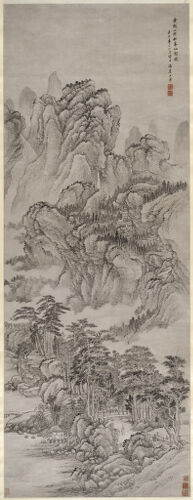

In [8]:
img_dataset[0].get("image")

## 2. Process Image

(References: 
https://huggingface.co/docs/diffusers/v0.27.2/en/training/text2image  
https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py#L40  
https://pytorch.org/vision/main/transforms.html  
)

This step should be moved to EMR, which includes
+ Resize Image to 512x512 (with Bilinear interpolation) (For stable diffusion 512 seems to be the optimal size, but for some images it might distort the images, so we might want to consider just add padding?)
+ normalize images

In [9]:
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode

In [10]:
transform_pipeline = v2.Compose([
    # TODO
    # Instead of resize, enlarge the photo by ratio and add padding
    v2.Resize(size=(512, 512), interpolation=InterpolationMode.LANCZOS),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


new_img = transform_pipeline(img_dataset[0].get("image"))

/Users/mynguyen/Repos/METCS777-GenAIForTheme/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [11]:
new_img.shape

torch.Size([3, 512, 512])

## 3. Process Caption
To process caption (in english), we need a Cliptextmodel
+ https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel  
+ https://huggingface.co/runwayml/stable-diffusion-v1-5  
+ https://huggingface.co/openai/clip-vit-large-patch14  

In [12]:
from transformers import CLIPTextModel, CLIPTokenizer
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

## 4. Setup VAE, UNET and remaining part of architecture
other args we can try, like whether to use EMA or not https://huggingface.co/stabilityai/stable-diffusion-2-1/discussions/22

In [13]:
# Getting the model weights from the pretrained models hub
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="vae"
)

unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="unet"
)


## 5. Get a scheduler for adding noise

In [ ]:
from diffusers import LMSDiscreteScheduler
noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

## 6. Training loop
This train loop is referenced from Huggingface training script https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py#L912

Ref: https://huggingface.co/docs/accelerate/quicktour  


In [42]:
import torch
import torch.nn.functional as F
from accelerate import Accelerator

In [40]:
# TODO: add checkpoint and resume from checkpoint

In [17]:
def preprocess_train(examples):
    # examples are a batch of 4 images
    # we apply the transformation (reference above for what it transfomed to)
    # then apply the tokenization
    examples["pixel_values"] = [transform_pipeline(image) for image in examples]
    examples["input_ids"] = tokenizer(examples).input_ids
    return examples

def collate_fn(examples):
    """
    Collate Function is used to create a batch
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

lr = 0.001
batch_size = 4
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
train_set = img_dataset.with_transform(preprocess_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn, num_workers=1)
accelerator = Accelerator()
device = accelerator.device



In [41]:
train_set

Dataset({
    features: ['image', 'caption'],
    num_rows: 93
})

# TODO:
A bit research on Adding noise step:
+ input_perturbation
+ noise_offset

Prediction Type: epsilon vs v_prediction 
https://medium.com/@zljdanceholic/three-stable-diffusion-training-losses-x0-epsilon-and-v-prediction-126de920eb73


In [ ]:

epochs = 2
weight_dtype = torch.float32

unet, optimizer, train_loader, noise_scheduler = accelerator.prepare(
    unet, optimizer, train_loader, noise_scheduler
)

prediction_type = "v_prediction"
for epoch in epochs:
    train_loss = 0.0

    for step, batch in enumerate(train_loader):
        # First encode the image to laten space with the VAE encoder
        latent = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()

        # sample noise to add to latent
        noise = torch.randn_like(latent)
        bsz = latent.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latent.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latent, noise, timesteps)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]

        # Get the target for loss depending on the prediction type
        if prediction_type is not None:
            # set prediction_type of scheduler if defined
            noise_scheduler.register_to_config(prediction_type=prediction_type)

        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latent, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        
        # Backpropagate
        accelerator.backward(loss)
        if accelerator.sync_gradients:
            accelerator.clip_grad_norm_(unet.parameters(), 1)
        optimizer.step()
        noise_scheduler.step()
        optimizer.zero_grad()